## Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.optimize as sco
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kurtosis, skew, shapiro, norm

## Data

In [3]:
data = pd.read_csv('./input/Quant_Invest_Fundusze.csv', sep=';')
data.index = pd.to_datetime(data['Daty'])
data['Daty'] = pd.to_datetime(data['Daty'])  # duplicated index for easy use of seaborn
ts_cols = [col for col in data.columns if not col == 'Daty']
data[ts_cols] = data[ts_cols].astype(np.float32) # reduce float size for speed and less RAM
data.sort_index(inplace=True)

In [4]:
weekly = data.drop(['Daty'], axis = 1).resample('W-MON').first() # resample.('W') gives significantly higher srri xD 
w_returns = weekly.pct_change().iloc[1:]

In [5]:
w_returns.head()

,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,
2000-01-10,-0.027627,-0.027718,0.007589,0.000399,0.000000,-0.000211,-0.004724
2000-01-17,0.082219,0.005638,-0.003696,0.003014,-0.000036,-0.001827,-0.005095
2000-01-24,0.002491,0.003688,0.044376,0.003080,-0.000073,-0.002196,0.002101
2000-01-31,-0.041413,-0.024885,-0.038992,0.003095,-0.000073,0.006178,0.004543
2000-02-07,0.030268,-0.002303,-0.007532,0.003110,0.007417,0.002188,-0.006174


In [11]:
w_returns.mean()*52

AP     0.066125
ARR    0.042488
ARW    0.074364
G      0.047951
OP     0.068486
ORR    0.034698
ORW    0.079968
dtype: float32

## SRRI

In [7]:
def srri_variance(w_returns: pd.DataFrame, **kw:'weights list'):
    
    period = min(w_returns.shape[0], 260)
    
    last_5y = w_returns.iloc[-period:]

    variance_df = last_5y.sub(last_5y.mean(),axis = 1).apply(lambda x: x**2)
    
    variance_vector = np.sqrt(variance_df.sum()*(52/(period-1)))
    
    if('weights' in kw):
        portfolio_variance = sum(np.multiply(variance_vector, kw['weights']))
        return(portfolio_variance)
    else:
        return(variance_vector)

    

In [8]:
srri_variance(w_returns,weights = [1/7 for i in range(7)]) # equal, 

0.0713846359659718

In [13]:
srri_variance(w_returns)

AP     0.135470
ARR    0.108197
ARW    0.142467
G      0.000484
OP     0.026650
ORR    0.029183
ORW    0.057241
dtype: float32

## Testing for Normality

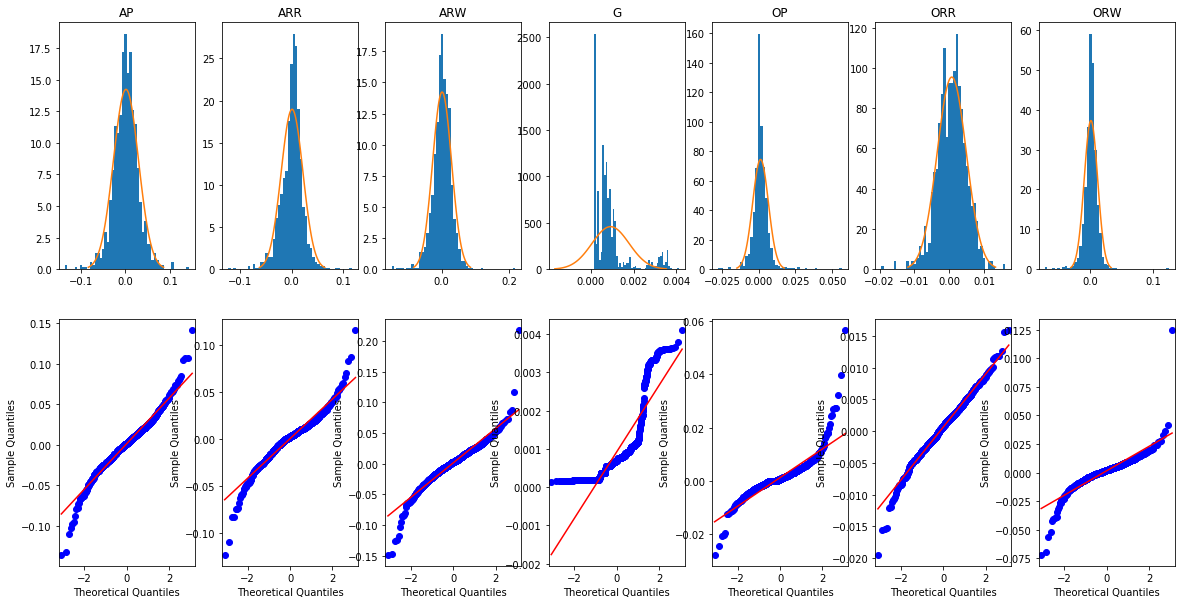

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(20,10))

for i, col in enumerate(w_returns.columns):
  mu = np.mean(w_returns[col])
  sigma = np.std(w_returns[col])
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  
  ax[0,i].hist(w_returns[col], bins =50, density = True)
  ax[0,i].plot(x,norm.pdf(x, mu, sigma))
  ax[0,i].set_title(col)
  qqplot(w_returns[col], line='s', ax =ax[1,i] )
  
plt.show()



## Risk to return

In [28]:
risk_return = pd.DataFrame({'SRRI':srri_variance(w_returns), 'Mean_Returns':w_returns.mean()*52, 'type':w_returns.columns}, index = None)

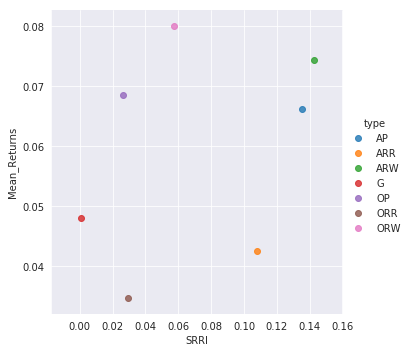

In [32]:
sns.set_style("darkgrid")
sns.lmplot('SRRI', 'Mean_Returns', data=risk_return, hue='type', fit_reg=False)